# **Air quality - GIOS data analysis**
### Advanced Databases
### Automatic Control and Robotic, Cyber-physical Systems
#### **Daniel Jurkowski (407200), Adam Pękala (405380), Rafał Maciasz (405560), Jakub Sacha (405521)**

#### **1. Import required packages** 

In [1]:
# Database driver
import psycopg2 as pg

# Data handling
import requests as req
import schedule
import time
import pandas as pd
import openpyxl
import numpy as np

# Visualization
import folium
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.graph_objects as go
import datetime
import warnings

# ORM
from sqlalchemy.orm import declarative_base
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float, DateTime
from sqlalchemy.sql import func
from sqlalchemy_utils import database_exists, create_database

# Other
import time

docker compose build

docker compose up

#### **2. Connect to database**

It is recommended to use 'scripts/postgres_db.sh' to clear the database and create a new one, then run whole notebook.

In [2]:
db_name = 'gios_data'
db_user = 'postgres'
db_password = 'kochamadb'
db_host = 'localhost'
db_port = '5000'

conn = pg.connect(
    dbname=db_name,
    user=db_user,
    password=db_password,
    host=db_host,
    port='5000'
)

#### **3. Scrap and explore data structure from API**

##### **3.1. GET /pjp-api/rest/station/findAll** - List of all stations with cities details

In [3]:
stations_data = pd.DataFrame.from_dict(req.get("https://api.gios.gov.pl/pjp-api/v1/rest/station/findAll?size=500").json()['Lista stacji pomiarowych'])
stations_data.rename(columns={"Identyfikator stacji": "stationId", "Kod stacji": 'stationCode', "Nazwa stacji": "stationName", "Ulica": "addressStreet", "Identyfikator miasta": "cityId",
                              "Gmina": "communeName", "Powiat": "districtName", "Województwo": "provinceName", "WGS84 φ N": "gegrLat", "WGS84 λ E": "gegrLon", "Nazwa miasta": "cityName"}, inplace=True)

cities_data = stations_data[["cityId", "cityName", "communeName", "districtName", "provinceName"]]
stations_data.drop(columns=["cityName", "communeName", "districtName", "provinceName"], inplace=True)

In [4]:
stations_data.head()

,stationId,stationCode,stationName,gegrLat,gegrLon,cityId,addressStreet
0,11,DsCzerStraza,Czerniawa,50.912475,15.312190,142,ul. Strażacka 7
1,16,DsDziePilsud,"Dzierżoniów, ul. Piłsudskiego",50.732817,16.648050,198,ul. Piłsudskiego 26
2,38,DsKlodzSzkol,"Kłodzko, ul. Szkolna",50.433493,16.653660,368,ul. Szkolna 8
3,52,DsLegAlRzecz,"Legnica, al. Rzeczypospolitej",51.204503,16.180513,453,al. Rzeczypospolitej 10/12
4,70,DsOlawZolnAK,"Oława, ul. Żołnierzy Armii Krajowej",50.942073,17.291333,642,ul. Żołnierzy AK 9


In [5]:
cities_data.head()

,cityId,cityName,communeName,districtName,provinceName
0,142,Czerniawa,Świeradów-Zdrój,lubański,DOLNOŚLĄSKIE
1,198,Dzierżoniów,Dzierżoniów,dzierżoniowski,DOLNOŚLĄSKIE
2,368,Kłodzko,Kłodzko,kłodzki,DOLNOŚLĄSKIE
3,453,Legnica,Legnica,Legnica,DOLNOŚLĄSKIE
4,642,Oława,Oława,oławski,DOLNOŚLĄSKIE


##### **3.2. GET /pjp-api/rest/station/sensors/{station_id}** - List of all sensors available within station with parameters details

In [6]:
sensors_data = pd.DataFrame.from_dict(sum([req.get(f"https://api.gios.gov.pl/pjp-api/rest/station/sensors/{station_id}").json() for station_id in stations_data["stationId"]], []))
sensors_data.rename(columns={"id": "sensorId"}, inplace=True)

params_data = pd.DataFrame.from_dict(list(sensors_data["param"]))
params_data.rename(columns={"idParam": "paramId"}, inplace=True)

sensors_data = pd.concat([sensors_data, params_data], axis=1)
sensors_data.drop(columns=["param", "paramCode"], inplace=True)

params_data = params_data.drop_duplicates(subset=["paramId"], keep="last").reset_index(drop=True)
params_data = params_data.drop(columns=["paramCode"])

In [7]:
sensors_data.head()

,sensorId,stationId,paramName,paramFormula,paramId
0,50,11,dwutlenek azotu,NO2,6
1,52,11,ozon,O3,5
2,54,11,pył zawieszony PM10,PM10,3
3,101,16,pył zawieszony PM10,PM10,3
4,221,38,dwutlenek azotu,NO2,6


In [8]:
params_data.head()

,paramName,paramFormula,paramId
0,benzen,C6H6,10
1,pył zawieszony PM2.5,PM2.5,69
2,dwutlenek siarki,SO2,1
3,pył zawieszony PM10,PM10,3
4,ozon,O3,5


#### **4. Design and implementation of database**

##### **4.1 Entity-Relationship Diagram**
![alt text](img/db_graph.png)

##### **4.1 Object-relation mapping**

In [9]:
Base = declarative_base()

class Cities(Base):
    __tablename__ = 'cities'
    city_id = Column(Integer, primary_key=True)
    name = Column(String(255))
    province = Column(String(255))

class Stations(Base):
    __tablename__ = 'stations'
    station_id = Column(Integer, primary_key=True)
    city_id = Column(Integer, ForeignKey('cities.city_id'))
    name = Column(String(255), unique=True)
    code = Column(String(255), unique=True)
    address_street = Column(String(255))
    latitude = Column(Float)
    longitude = Column(Float)
    
class Parameters(Base):
    __tablename__ = 'params'
    param_id = Column(Integer, primary_key=True)
    name = Column(String(255))
    formula = Column(String(255))
    
class Sensors(Base):
    __tablename__ = 'sensors'
    sensor_id = Column(Integer, primary_key=True)
    station_id = Column(Integer, ForeignKey('stations.station_id'))
    param_id = Column(Integer, ForeignKey('params.param_id'))
    
class ActualMeasurements(Base):
    __tablename__ = 'actual_measurements'
    pk = Column(Integer, primary_key=True)
    sensor_id = Column(Integer, ForeignKey('sensors.sensor_id'),)
    sensor_code = Column(String(255))
    date_time = Column(DateTime(timezone=True), default=func.now())
    value = Column(Float)
    
class ArchiveMeasurements(Base):
    __tablename__ = 'archive_measurements'
    pk = Column(Integer, primary_key=True)
    station_code = Column(String(255))
    sensor_code = Column(String(255))
    date_time = Column(DateTime(timezone=True), default=func.now())
    value = Column(Float)
    
class AirQuality(Base):
    __tablename__ = 'air_quality'
    pk = Column(Integer, primary_key=True)
    station_id = Column(Integer, ForeignKey('stations.station_id'))
    date_time = Column(DateTime(timezone=True), default=func.now())
    index_value = Column(Integer)
    index_name = Column(String(255))
    
db_info = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
db = create_engine(db_info)

if not database_exists(db.url):
    create_database(db.url)
else:
    db.connect()
    Base.metadata.create_all(db)

##### **4.2 Inserting scrapped data structures to database**

In [10]:
with conn:
    with conn.cursor() as cur:
        for _, record in cities_data.iterrows():
            cur.execute(f'''
                INSERT INTO cities (city_id, name, province)
                VALUES ({record["cityId"]}, '{record["cityName"]}', '{record["provinceName"]}')
                ON CONFLICT (city_id) DO NOTHING;
            ''')
        conn.commit()

        for _, record in stations_data.iterrows():
            cur.execute(f'''
                INSERT INTO stations (station_id, city_id, name, code, address_street, latitude, longitude)
                VALUES ({record["stationId"]}, {record["cityId"]}, '{record["stationName"]}', '{record["stationCode"]}', '{record["addressStreet"]}', '{record["gegrLat"]}', '{record["gegrLon"]}')
                ON CONFLICT (station_id) DO NOTHING;
            ''')
            
        for _, record in params_data.iterrows():
            cur.execute(f'''
                INSERT INTO params (param_id, name, formula)
                VALUES ({record["paramId"]}, '{record["paramName"]}', '{record["paramFormula"]}')
                ON CONFLICT (param_id) DO NOTHING;
            ''')
        conn.commit()

        for _, record in sensors_data.iterrows():
            cur.execute(f'''
                INSERT INTO sensors (sensor_id, station_id, param_id)
                VALUES ({record["sensorId"]}, {record["stationId"]}, {record["paramId"]})
                ON CONFLICT (sensor_id) DO NOTHING;
            ''')
            
        conn.commit()

#### **5. Inserting measurements to database**

##### **5.1 GET /pjp-api/v1/rest/data/getData/{idSensor}** - A web service that makes measurement data available based on the given measurement station ID, from the last full hour to the third day back. Measurement results are made available in local time, i.e. in summer in CEST time (UTC+ 02:00, Central European Summer Time), and in winter in CET time (UTC+ 01:00, Central European Winter Time)

A query for inserting data of air pollution from all available sensors.
Approximate time of execution is 1.5 minutes.

In [11]:
def fetch_data_from_api(api_url):
    response = req.get(api_url)
    if response.status_code == 200:
        return response.json()
    else:
        print(response)
        return None

In [12]:
def insert_data_to_db(conn, data, idx):    
    with conn:
        with conn.cursor() as cur:
            if data['Lista danych pomiarowych']:
                for measurement in data['Lista danych pomiarowych']:
                    if measurement['Wartość'] is not None:
                        cur.execute(f'''
                            INSERT INTO actual_measurements (sensor_id, sensor_code, date_time, value)
                            VALUES ({idx}, '{measurement['Kod stanowiska']}', '{measurement['Data']}', {measurement['Wartość']});
                        ''')
                conn.commit()
    
all_ids = sensors_data["sensorId"]
for id in all_ids:
    api_url = f'https://api.gios.gov.pl/pjp-api/v1/rest/data/getData/{id}?size=500'

    data = fetch_data_from_api(api_url)

    if data:
        insert_data_to_db(conn, data, id)

##### **5.2 GET - /pjp-api/v1/rest/archivalData/getDataBySensor/{idSensor}** - A web service that makes available archived measurement data based on the given measurement site ID. One-hour measurement results are always made available in CET time (UTC+ 01:00, Central European Winter Time)

A query for inserting data of air pollution from all stations from 2023 for PM10 and PM2.5 parameters, mean from 24 hours.

In [13]:
with conn:
    with conn.cursor() as cur:
        cur.execute("SELECT * from params p WHERE p.formula='PM2.5' OR p.formula='PM10'")
        rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['param_id','name', 'formula'])
df

,param_id,name,formula
0,69,pył zawieszony PM2.5,PM2.5
1,3,pył zawieszony PM10,PM10


In [14]:
with conn:
    with conn.cursor() as cur:
        cur.execute("SELECT * from sensors s WHERE s.param_id=3")
        rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['sensor_id','station_id', 'param_id'])
sensors_pm25_ids = df['sensor_id'].values
df

,sensor_id,station_id,param_id
0,54,11,3
1,101,16,3
2,224,38,3
3,14397,52,3
4,400,70,3
...,...,...,...
176,29267,17438,3
177,29514,17741,3
178,29550,17758,3
179,29567,17780,3


In [15]:
with conn:
    with conn.cursor() as cur:
        cur.execute("SELECT * from sensors s WHERE s.param_id=69")
        rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['sensor_id','station_id', 'param_id'])
sensors_pm10_ids = df['sensor_id'].values
df

,sensor_id,station_id,param_id
0,25988,38,69
1,670,117,69
2,744,129,69
3,966,156,69
4,996,158,69
...,...,...,...
92,29268,17438,69
93,29390,17658,69
94,29516,17741,69
95,29556,17758,69


Request for archival data is limited to 2 per minute. So there is no possibility to get all data for these sensors in reasonable time while using pagination. Approximate time of execution is 1.5 hour.

In [16]:
# def insert_data_to_db(conn, data, idx):    
#     with conn:
#         with conn.cursor() as cur:
#             if data['Lista danych pomiarowych']:
#                 for measurement in data['Lista danych pomiarowych']:
#                     if measurement['Wartość'] is not None:
#                         cur.execute(f'''
#                             INSERT INTO archive_measurements (station_code, sensor_code, date_time, value)
#                             VALUES (measurement['Nazwa stacji'], '{measurement['Kod stanowiska']}', '{measurement['Data']}', {measurement['Wartość']});
#                         ''')
#                 conn.commit()
    
# all_ids = sensors_data["sensorId"]
# for id in all_ids:
#     api_url = f'https://api.gios.gov.pl/pjp-api/v1/rest/data/getData/{id}?size=500'

#     data = fetch_data_from_api(api_url)

#     if data:
#         insert_data_to_db(conn, data, id)

# def insert_data_to_db(conn, data, idx):
#     with conn:
#         with conn.cursor() as cur:
#             if data['Lista archiwalnych wyników pomiarów']:
#                 for measurement in data['Lista archiwalnych wyników pomiarów']:
#                     if measurement['Wartość'] is not None:
#                         cur.execute(f'''
#                             INSERT INTO archive_measurements (sensor_id, sensor_code, date_time, value)
#                             VALUES ({idx}, '{measurement['Kod stanowiska']}', '{measurement['Data']}', {measurement['Wartość']});
#                         ''')
#                 conn.commit()
                
# def get_api_url(id, page):
#     return f'https://api.gios.gov.pl/pjp-api/v1/rest/archivalData/getDataBySensor/{id}?page={page}&size=500&dateFrom=2023-01-01%2000%3A00&dateTo=2023-12-31%2000%3A00'

# for id in sensors_pm25_ids:
#     page=0

#     while True:
#         data = fetch_data_from_api(get_api_url(id, page))

#         if data:
#             insert_data_to_db(conn, data, id)
#         else:
#             break
        
#         page += 1
#         time.sleep(60)

Instead, we got this data from CSV provided by the GIOS website.

In [17]:
data_sensor_pm25 = pd.read_excel('data/2023_PM25_24g.xlsx')
data_sensor_pm25 = data_sensor_pm25.drop([1, 2, 3, 4])
data_sensor_pm25.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
stations_codes = [i for i in data_sensor_pm25[:1].values[0][1:]]

query = """SELECT s.code AS station_code, c.name AS city
FROM stations s
JOIN cities c ON s.city_id = c.city_id
"""

with conn:
    with conn.cursor() as cur:
        cur.execute(query)
        rows = dict(cur.fetchall())

columns_names = dict()       
for idx, code in enumerate(stations_codes):
    try:
        columns_names[idx + 1] = f'{code} | {rows[code]}'
    except KeyError:
        columns_names[idx + 1] = f'{code}'


data_sensor_pm25.rename(columns=columns_names, inplace=True)
data_sensor_pm25 = data_sensor_pm25.drop([0])
data_sensor_pm25['Date'] = pd.to_datetime(data_sensor_pm25['Date'])
data_sensor_pm25 = data_sensor_pm25.reset_index(drop=True)
data_sensor_pm25.head()

,Date,DsLegPolarna | Legnica,DsOsieczow21 | Osieczów,DsWalbrzWyso | Wałbrzych,DsWrocNaGrob | Wrocław,DsZgorBohGet | Zgorzelec,KpBydFieldor | Bydgoszcz,KpGrudSienki | Grudziądz,KpToruDziewu | Toruń,KpWloclGniaz | Włocławek,...,WmOlsPuszkin | Olsztyn,WmOstrPilsud | Ostróda,WmPuszczaBor | Diabla Góra,WpKaliSawick | Kalisz,WpPleszAlMic | Pleszew,WpPoznSzwajc | Poznań,ZpKoszSpasow | Koszalin,ZpMyslZaBram | Myślibórz,ZpSzczAndrze | Szczecin,ZpSzczec1Maj | Szczecinek
0,2023-01-01,13.6,9.8,12.1,15,15.5,4.4,12.6,9.7,12.7,...,12.31,9.86,9.69,11.9,12.2,14.2,11.1,45,14.1,8.3
1,2023-01-02,15.3,10.3,12.6,14.6,13.6,12.4,20.3,14.1,16.2,...,13.89,14.34,12.32,16.1,NaN,14.2,7.4,6.7,6.7,8.2
2,2023-01-03,20,11.5,26.1,13.6,11.7,5.2,10.7,5.6,7.3,...,3.27,4.97,3.9,15.5,NaN,9.7,4.7,13.2,4,4.2
3,2023-01-04,10,10.1,16.5,18.5,11.1,12.2,16.2,14.5,18.9,...,11.35,11.64,8.35,19.1,NaN,17.4,6.2,7.3,4,6.3
4,2023-01-05,4.9,3.6,4.8,6.1,5.5,4.2,6.4,2.9,3,...,1.58,4,4.05,3.2,10.3,3.8,2.7,4,3.1,2.7


In [18]:
data_sensor_pm10 = pd.read_excel('data/2023_PM10_24g.xlsx')
data_sensor_pm10 = data_sensor_pm10.drop([1, 2, 3, 4])
data_sensor_pm10.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
stations_codes = [i for i in data_sensor_pm10[:1].values[0][1:]]

query = """SELECT s.code AS station_code, c.name AS city
FROM stations s
JOIN cities c ON s.city_id = c.city_id
"""

with conn:
    with conn.cursor() as cur:
        cur.execute(query)
        rows = dict(cur.fetchall())
        
columns_names = dict()       
for idx, code in enumerate(stations_codes):
    try:
        columns_names[idx + 1] = f'{code} | {rows[code]}'
    except KeyError:
        columns_names[idx + 1] = f'{code}'
    
data_sensor_pm10.rename(columns=columns_names, inplace=True)
data_sensor_pm10 = data_sensor_pm10.drop([0])
data_sensor_pm10['Date'] = pd.to_datetime(data_sensor_pm10['Date'])
data_sensor_pm10 = data_sensor_pm10.reset_index(drop=True)
data_sensor_pm10.head()

,Date,DsGlogWiStwo | Głogów,DsJelGorSoko | Jelenia Góra,DsLegAlRzecz | Legnica,DsLwowekSlasMOB,DsNowRudJezi | Nowa Ruda,DsOlawZolnAK | Oława,DsOlesBrzozo | Oleśnica,DsOsieczow21 | Osieczów,DsPolanZdrojMOB,...,WpPoznSzyman | Poznań,WpWagrowLipo | Wągrowiec,ZpKolZolkiew | Kołobrzeg,ZpKoszChopin | Koszalin,ZpMyslZaBram | Myślibórz,ZpSwinMatejkMOB,ZpSzczAndrze | Szczecin,ZpSzczec1Maj | Szczecinek,ZpSzczecPrze | Szczecinek,ZpSzczPilsud | Szczecin
0,2023-01-01,17.5,15.3,19.4,23.3,70.5,13.7,17.5,14,NaN,...,18.76,19.68,15.3,22.7,NaN,15.8,18,15.1,20,16.9
1,2023-01-02,31.1,12.8,24.2,28.2,108.1,16.8,24.4,14.6,NaN,...,19.8,25.27,11.3,12.2,NaN,9.6,11.4,16.1,17.6,14.5
2,2023-01-03,20.6,12.1,33,39.1,60.1,21.6,21.8,14.7,NaN,...,13.64,20.2,12.6,12.2,14.9,10.9,9.4,10.7,14,16
3,2023-01-04,11.9,12.8,14.6,23.9,48.7,16.8,23.1,12.1,NaN,...,19.49,21.8,8,9.1,8.7,7.5,6.2,10.9,11.2,10
4,2023-01-05,NaN,5.3,6.4,7.9,6.4,7.4,8.9,6.4,NaN,...,5.13,5.81,7.8,5.3,5.5,4.5,6.3,5.1,6.9,7.1


#### **6. Data visualization**  
##### **6.1 Air quality stations in Poland**

In [19]:
cities_df = pd.read_sql_query("SELECT * FROM cities;", conn)
stations_df = pd.read_sql_query("SELECT city_id, latitude, longitude, name FROM stations;", conn)

m = folium.Map(location=[52.2297, 21.0122], zoom_start=7)  # Poland
marker_cluster = MarkerCluster().add_to(m)

for idx, row in stations_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
    ).add_to(marker_cluster)

warnings.filterwarnings("ignore")
m

/tmp/ipykernel_102456/60587076.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cities_df = pd.read_sql_query("SELECT * FROM cities;", conn)
/tmp/ipykernel_102456/60587076.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stations_df = pd.read_sql_query("SELECT city_id, latitude, longitude, name FROM stations;", conn)


##### **6.1 PM10 & PM2.5 pollution levels from the previous day in the biggest cities**

In [20]:
stations_df = pd.read_sql_query("SELECT station_id, city_id, name, latitude, longitude FROM stations;", conn)
cities_df = pd.read_sql_query("SELECT city_id, name FROM cities;", conn)

cities_of_interest = ["Warszawa", "Kraków", "Wrocław", "Łódź", "Poznań", 
                      "Gdańsk", "Szczecin", "Lublin", "Bydgoszcz", "Białystok"]

filtered_cities_df = cities_df[cities_df['name'].isin(cities_of_interest)]
filtered_stations_df = stations_df[stations_df['city_id'].isin(filtered_cities_df['city_id'])]

one_day_ago = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
measurements_query = f"""
    SELECT s.city_id, c.name AS city_name, am.date_time, am.value
    FROM actual_measurements am
    JOIN sensors se ON am.sensor_id = se.sensor_id
    JOIN stations s ON se.station_id = s.station_id
    JOIN cities c ON s.city_id = c.city_id
    JOIN params p ON se.param_id = p.param_id
    WHERE DATE(am.date_time) = DATE('{one_day_ago}')
      AND p.formula = 'PM10'
      AND s.city_id IN ({','.join(map(str, filtered_cities_df['city_id'].tolist()))})
"""


measurements_df = pd.read_sql_query(measurements_query, conn)

measurements_df['date_time'] = pd.to_datetime(measurements_df['date_time'])
measurements_df['value'] = pd.to_numeric(measurements_df['value'], errors='coerce')
average_data = measurements_df.groupby(['city_name', pd.Grouper(key='date_time', freq='H')])['value'].mean().reset_index()

warnings.filterwarnings("ignore")

fig = px.line(average_data, x='date_time', y='value', color='city_name', title='PM10 pollution levels from the previous Day')
fig.update_layout(xaxis_title='Time', yaxis_title='Pollution level (µg/m³)', hovermode='closest')

fig.show()

In [21]:
measurements_query = f"""
    SELECT s.city_id, c.name AS city_name, am.date_time, am.value
    FROM actual_measurements am
    JOIN sensors se ON am.sensor_id = se.sensor_id
    JOIN stations s ON se.station_id = s.station_id
    JOIN cities c ON s.city_id = c.city_id
    JOIN params p ON se.param_id = p.param_id
    WHERE DATE(am.date_time) = DATE('{one_day_ago}')
      AND p.formula = 'PM2.5'
      AND s.city_id IN ({','.join(map(str, filtered_cities_df['city_id'].tolist()))})
"""

measurements_df = pd.read_sql_query(measurements_query, conn)

measurements_df['date_time'] = pd.to_datetime(measurements_df['date_time'])
measurements_df['value'] = pd.to_numeric(measurements_df['value'], errors='coerce')
average_data = measurements_df.groupby(['city_name', pd.Grouper(key='date_time', freq='H')])['value'].mean().reset_index()

warnings.filterwarnings("ignore")

fig = px.line(average_data, x='date_time', y='value', color='city_name', title='PM2.5 pollution levels from the previous day')
fig.update_layout(xaxis_title='Time', yaxis_title='PPollution level (µg/m³)', hovermode='closest')

fig.show()

##### **6.2 Average PM10 & PM2.5 pollution levels from 2023 based on air quality measuring stations**

In [22]:
station_dropdown = [{'label': station, 'value': station} for station in data_sensor_pm10.columns[1:]]

fig = px.line(data_sensor_pm10, x='Date', title='Average PM10 pollution levels in 2023', labels={'value': 'Pollution level (µg/m³)'})

fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{'y': [data_sensor_pm10[station]]}],
                    label=station,
                    method='update'
                ) for station in data_sensor_pm10.columns[1:]
            ]),
            direction='down',
            pad={'r': 10, 't': 10},
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.1,
            yanchor='top'
        ),
    ]
)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(xaxis_title='Time', yaxis_title='Pollution level (µg/m³)', hovermode='closest')
fig.show()

In [23]:
station_dropdown = [{'label': station, 'value': station} for station in data_sensor_pm25.columns[1:]]

fig = px.line(data_sensor_pm25, x='Date', title='Average PM2.5 pollution levels in 2023', labels={'value': 'Pollution level (µg/m³)'})

fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{'y': [data_sensor_pm25[station]]}, {'title': f'Average PM2.5 pollution levels in 2023 for {station}'}],
                    label=station,
                    method='update'
                ) for station in data_sensor_pm25.columns[1:]
            ]),
            direction='down',
            pad={'r': 10, 't': 10},
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.1,
            yanchor='top'
        ),
    ]
)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(xaxis_title='Time', yaxis_title='Pollution level (µg/m³)', hovermode='closest')
fig.show()

##### **6.3 Highest average PM10 & PM2.5 pollution levels for 2023**

In [24]:
import pandas as pd
from plotly.subplots import make_subplots
from plotly.subplots import make_subplots

mean_values_pm10 = data_sensor_pm10.drop(columns=['Date']).mean()
sorted_mean_values_pm10 = mean_values_pm10.sort_values(ascending=False)
top_mean_values_pm10 = sorted_mean_values_pm10[:15]

mean_values_pm25 = data_sensor_pm25.drop(columns=['Date']).mean()
sorted_mean_values_pm25 = mean_values_pm25.sort_values(ascending=False)
top_mean_values_pm25 = sorted_mean_values_pm25[:15]

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(
        x=top_mean_values_pm10.index,
        y=top_mean_values_pm10,
        name='PM10',
        visible=False
    ),
    secondary_y=False
)

fig.add_trace(
    go.Bar(
        x=top_mean_values_pm25.index,
        y=top_mean_values_pm25,
        name='PM2.5',
    ),
    secondary_y=False
)

fig.update_layout(
    title='Top 15 stations with the highest average pollution levels in 2023',
    xaxis=dict(title='Station name'),
    yaxis=dict(title='Pollution level (µg/m³)'),
    barmode='group',
    legend=dict(x=0.1, y=1.1, orientation='h'),
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label='PM10',
                    method='update',
                    args=[{'visible': [True, False]}, {'title': 'Top 15 stations with the highest average PM10 pollution levels in 2023'}]
                ),
                dict(
                    label='PM2.5',
                    method='update',
                    args=[{'visible': [False, True]}, {'title': 'Top 15 stations with the highest average PM2.5 pollution levels in 2023'}]
                )
            ],
            direction='down',
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.2,
            yanchor='top'
        )
    ]
)

fig.show()

#### **7. Real time data visualisation using Docker service**
##### **7.1 GET - /pjp-api/v1/rest/aqindex/getIndex/{stationId}** - Network service providing an air quality index based on the given measuring station identifier.


In order to realise real-time data acquisition and visualization to the database, service was created and deployed in docker container. 
It works independently of the machine on which the rest of the code is executed, updating the air quality table with new data every 30 seconds for few stations.

In [25]:
# Docker service detects if this table is present in the database, if yes it will start the service

class DockerService(Base):
    __tablename__ = 'docker'
    pk = Column(Integer, primary_key=True)
    
db_info = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
db = create_engine(db_info)

if not database_exists(db.url):
    create_database(db.url)
else:
    db.connect()
    Base.metadata.create_all(db)

In [26]:
with conn:
    with conn.cursor() as cur:
        cur.execute("SELECT * FROM cities;")
        rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['city_id', 'name', 'province'])

df.head()

,city_id,name,province
0,142,Czerniawa,DOLNOŚLĄSKIE
1,198,Dzierżoniów,DOLNOŚLĄSKIE
2,368,Kłodzko,DOLNOŚLĄSKIE
3,453,Legnica,DOLNOŚLĄSKIE
4,642,Oława,DOLNOŚLĄSKIE


In [27]:
import matplotlib.cm as cm
import matplotlib.colors as colors

Current number of records in the air_quality table: (105, 5)
   id  station_id                        date_time  index_value    index_name
0   1         114 2024-06-13 21:24:27.359128+00:00            0  Bardzo dobry
1   2         117 2024-06-13 21:24:27.668890+00:00            0  Bardzo dobry
2   3         129 2024-06-13 21:24:27.983486+00:00            1         Dobry
3   4          52 2024-06-13 21:24:28.506640+00:00            1         Dobry
4   5         109 2024-06-13 21:24:28.804342+00:00            0  Bardzo dobry


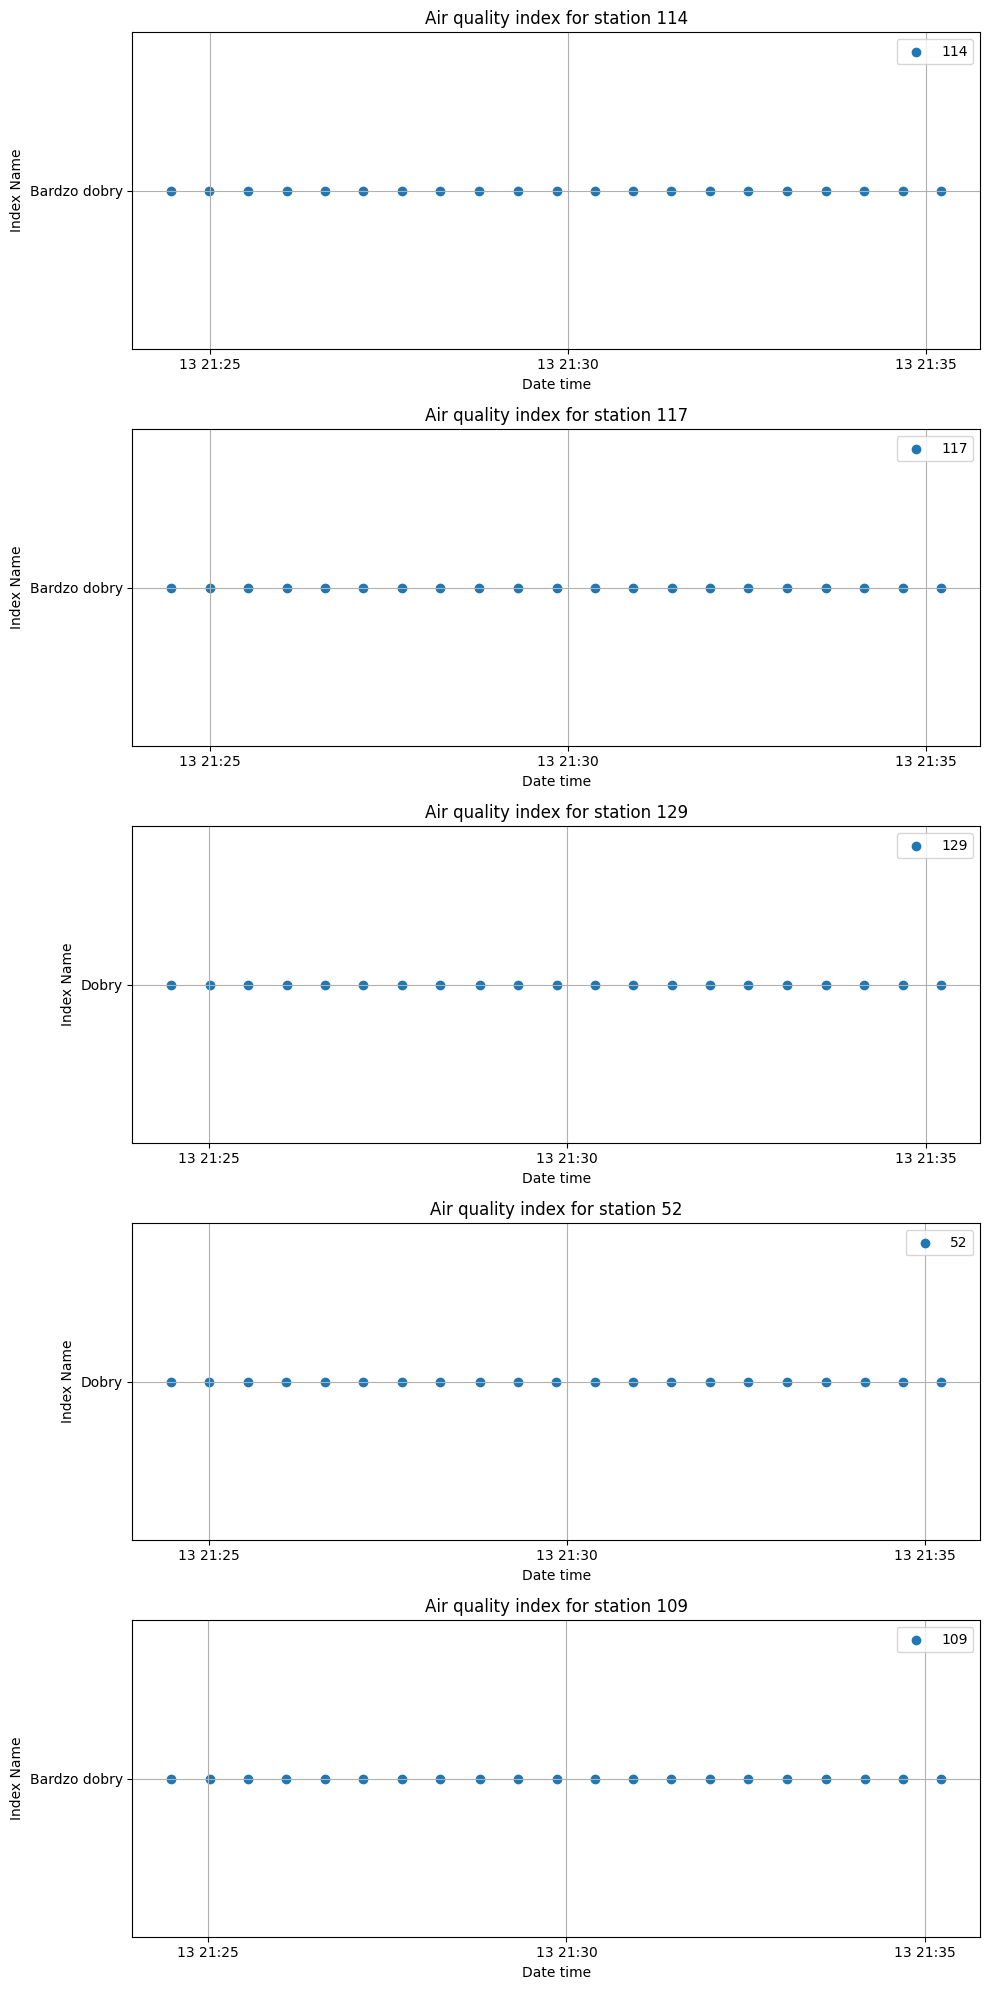

In [60]:
table_name = "air_quality"
with conn:
    with conn.cursor() as cur:
        cur = conn.cursor()
        cur.execute(f"SELECT * FROM {table_name};")
        rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['id', 'station_id', 'date_time', 'index_value', 'index_name'])

print(f"Current number of records in the {table_name} table: {df.shape}")
print(df.head())

table_name = "air_quality"
with conn:
    with conn.cursor() as cur:
        cur = conn.cursor()
        cur.execute(f"SELECT * FROM {table_name};")
        rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['id', 'station_id', 'date_time', 'index_value', 'index_name'])

fig, ax = plt.subplots(5, 1, figsize=(10, 20))
for i, station_id in enumerate(df['station_id'].unique()):
    station_data = df[df['station_id'] == station_id]
    ax[i].scatter(station_data['date_time'], station_data['index_name'], label=station_id) 
    ax[i].set_xlabel('Date time')
    ax[i].set_ylabel('Index Name')
    ax[i].set_title(f'Air quality index for station {station_id}')
    ax[i].legend()
    ax[i].grid()
    
plt.tight_layout()
plt.show()
